# Morning: Introduction to Time Series Analysis
In this set of exercises we study the basic concepts of statistical time series. We focus on the foundational concepts of *autocorrelation* (https://en.wikipedia.org/wiki/Autocorrelation) and *periodicity* (or *seasonality*) (https://en.wikipedia.org/wiki/Seasonality). The meaning of these terms will become more clear over time. Being a statistics workshop, we'll focus on the general quantitative characteristics of time series that require attention to draw proper statistical conclusions from data. This essentially boils down to understanding the consequences of spatial-temporal properties on the calculation of confidence intervals, p.values, posterior probabilities, and other related metrics that quantify statistical evidence. Understanding autocorrelation and periodicity will take us a long way to this goal. 

To get started with analysis, we will first clear our R workspace:

In [31]:
rm(list=ls())      #remove data from workspace
library(nlme)      #pacakge to fit various regression models with autocorrelation

## Is there a trend?
Here we read in our first real dataset that exhibits typical properties of environmental time series, and of time series more generally. The measurements are of monthly-averaged sea surface temeprature (SST) for a region of the sea surface enclosed by 5°N–5°S, 120°–170°W, recorded by the National Oceanic and Atmospheric Adminstration (NOAA) and published publically to their website. This particular measurement is widely used as an index of the El Nino phenomena (https://en.wikipedia.org/wiki/El_Ni%C3%B1o) that plays an important role in global climate, and Californian climate in particular. The sea surface measurement represent monthly temperature averages (12 measurements per year) taken by series of measurement techniques including moored buoys and in-situ sampling, averaged according to an assumed measurement error of each technique.  

In R, we define the dataset ``sst``, our variable of interest ``y`` (sea surface temperature), and the time variable ``t`` (months). 

We then go ahead and plot the data in R. 

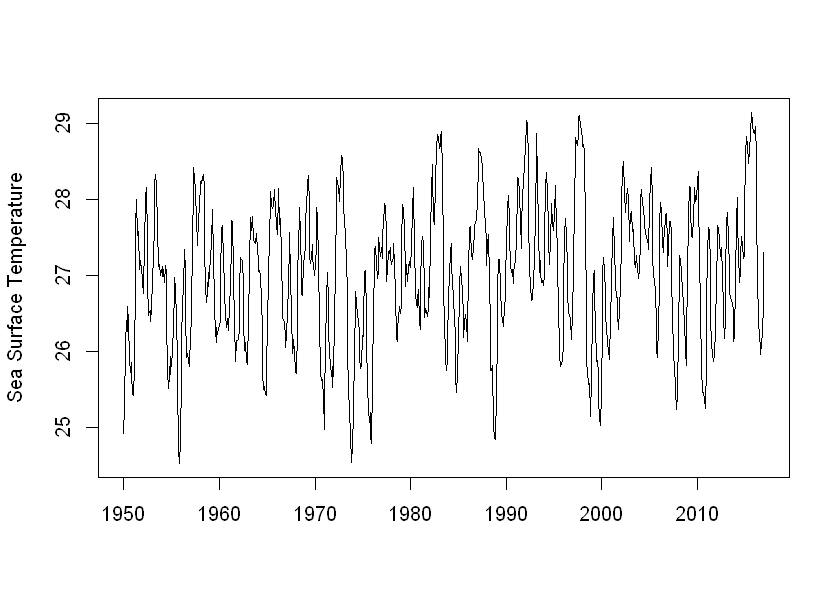

In [32]:
sst <- read.table('../../Data/detrend.nino34.ascii.txt',header=TRUE)  #read monitoring data published to NOAA website
y   <- sst$TOTAL                                                      #define vector of SST measurements
t   <- seq(1950,2017,length.out=nrow(sst))                            #define time variable
options(repr.plot.width=7, repr.plot.height=5)                        #define dimensions of jupyter plot window
plot(t,y,type='l',xlab='',ylab='Sea Surface Temperature')             #make plot as a line

Our first question is perhaps the simplest and most common question asked in applied time series analysis: *Is there a trend over time?* Take a hard look at the plot and write down what you'd guess, yes or no. We'll go back and test our initial intuition after learning some spatial-temporal statistics.  

The simplest statistical trend model is a linear regression with respect to time

$$ y_i = \beta t_i + e_i $$

where $y_i$ indicates is a single observation which is a function of the slope with respect to time $\beta$ multiplied by the $t_i$ variable which represents the time elapsed from the beginning of the time series, while $e_i$ is the background variability not accounted for by the model. We assume $e_i$ has a *Normal* (or *Gaussian*) *distribution* which is often written $e_i \sim N(0,\sigma^2)$ where $\sigma^2$ is the variance. It will also be helpful to write the model in vector notation  

$$ \mathbf{y} = \beta \mathbf{t} + \mathbf{e} $$

where the bold-faced type indicates the full vector, or column, of values, with $\mathbf{t}$ representing the set of sequentially increasing time values, and $\mathbf{e}$ is a *random vector* with *covariance matrix* $\mathbf{\Sigma}$. We will learn to love the covariance matrix. It will be the central quantity required to extend basic statistical concepts to encompass spatial-temporal data. 

## Statistical independence
Statistical independence is a central idea in the workshop and is intimately related to concepts of covariance. Many statistical analysis proceed under the assumption of independence but this will often be violated when dealing with spatial-temporal data.  To jog your memory, the covariance between two *random variables* (i.e. a variable decribed by a statistical distribution, opposed to a single value) is 

$$ \mathrm{cov}(x,y) = \mathrm{E}\left[ (x-\mathrm{E}[x])(y-\mathrm{E}[y]) \right] $$

where the $\mathrm{E}$ is used in statistics to denote a theoretical average with respect to the random variables $x$ and $y$. With a sample of data, we calculate the *empirical* or *sample covariance*

$$ \mathrm{\hat{cov}}(x,y) = \frac{1}{n} \sum_{i=1}^n (x_i-\bar{x})(y_i-\bar{y}) $$

where the sum is taken over all individual data points $i$, while $\bar{x}$ and $\bar{y}$ represent the sample (arithmetic) average of $x$ and $y$, respectively, and $\hat{}$ notation represents an empirical estimate. Note that the correlation between two variables, $\mathrm{cor}(x,y)$ is simply the covariance devided by a measure of total variance (i.e. the correlation is the fraction of the total variance that is common to both variables)

$$ \mathrm{cor}(x,y) = \frac{\mathrm{cov}(x,y)}{\sigma_x \sigma_y}  $$

where $\sigma_x$ and $\sigma_y$ are the standard deviations for the variables $x$ and $y$, respectively. If the two variables are independent, then $\mathrm{cov}(x,y) = 0$ theoretically, and $\mathrm{\hat{cov}}(x,y) = 0$, on average based on *realizations of the random variable*.

In our regression model, the assumption of independence enters via the covariance matrix of the model errors. When a random vector is assumed to have independent elements, it has a covariance with diagonal elements representing the variances of each respective variable. If we assume that each variable has the same variance then the covariance matrix has the following form

$$ \mathbf{\Sigma}_{iid} = \begin{bmatrix}
	  	\sigma^2 &        0 &  \dots & 0 \\
  			   0 & \sigma^2 &   \dots & 0 \\
          \vdots &   \vdots &\ddots & \vdots  \\
               0 &        0 &\dots  & \sigma^2     \end{bmatrix} =
        \sigma^2 \begin{bmatrix}
	  	       1 &        0 &  \dots & 0 \\
  			   0 &        1 &  \dots & 0 \\
          \vdots &   \vdots &\ddots & \vdots  \\
               0 &        0 &\dots  & 1     \end{bmatrix} $$
               
where $\sigma^2$ is the variance, which is factored on the right as the multiplication of the variance times the correlation matrix. This diagonal (independent) form is the most commonly used form of the Gaussian distribution and is the basis of many basic models in statistics. 

In general, the way to intpret this matrix is as a big list of covariances (or correlations, depending on whether the variance is factored) between variables. In statistics we treat each data point as a random variable, where the paricular observation is the realized value from that random variable. So each $i^{th}$ column is a list of the covariances between datapoint $i$ and all datapoints in the dataset. When data are independent, all covariances are zero and so takes this simple diagonal form. 

## The likelihood function for independent data
The background theory for regression and many other statistical models is the likelihood function. It represents the probability of the observations under the assumption of a particular statistical distribution (https://en.wikipedia.org/wiki/Likelihood_function). We write the likelihood function for an independent random vector

$$ p(\mathbf{y} | \theta,M, \sigma^2) = \prod_{i=1}^n p(y_i | \theta,M,\sigma^2) = \left( \frac{1}{2\pi\sigma^2}\right)^{n/2} \mathrm{exp} \left( -\frac{\sum_{i=1}^n e_i^2}{2\sigma^2	}  \right) $$

This is the function that is maximized when one fits a basic statistical model. For linear models, there are often analytic expressions for the parameters that maximize this function, however numerical optimization is required for more complex statistical models. (See https://en.wikipedia.org/wiki/Proofs_involving_ordinary_least_squares#Maximum_likelihood_approach to see how the formula for linear regression are derived by maximizing the likelihood function.). Some may recall the compact expression from linear algebra that maximizes the likelihood of an ordinary least squares regression

$$ \mathbf{\hat{\beta}} = \mathbf{(X'X)^{-1}X'y}  $$

where $\mathbf{X}$ in this case is a matrix formed with a vector of ones and the variable $\mathbf{t}$ as its columns. 

Here is how we would fit this common regression model in ``R``:

In [33]:
summary(lm(y ~ t))   #return summary of the fitted model object lm(y~t)


Call:
lm(formula = y ~ t)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.4020 -0.6441  0.0608  0.6246  1.9709 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 10.688845   3.290339   3.249  0.00121 ** 
t            0.008230   0.001659   4.961 8.55e-07 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.9125 on 805 degrees of freedom
Multiple R-squared:  0.02967,	Adjusted R-squared:  0.02846 
F-statistic: 24.61 on 1 and 805 DF,  p-value: 8.551e-07


This is the typical output from a regression that ``R`` and ``Python`` users will be familiar with. It is referred to as the *t-table* or *ANOVA* table. While we won't get into what all the values mean, since these quantities are the focus of introductory courses, we will note the *t-statistic* which is formed by taking the ratio of the slope magnitude to the magnitude of its standard error

$$ t = \frac{\hat{\beta}}{s.e.(\hat{\beta})}   $$

which we will use as a rough-and-ready measure of statistical confidence in a particular estimate. We generally will not incorporate $p.value$ interpretations into our analysis, although one should recall that $p.value$ statements are derived from comparing the calculated $t$ statistic to a hypothethetical *t distribution* (https://en.wikipedia.org/wiki/Student%27s_t-test). As a rough rule of thumb, smallter $t$ values indicate lower confidence in the statistical presence of an effect.

## Temporal dependence
Now we look at a very simple time series model that violates the assumptions of temporal independence. And as we'll see, it's actually a very useful model to model time series in a variety of situations. This is the *first-order autoregressive model*, or *AR1*. We write this model

$$ y_{t+1} = \phi y_t + e_{t+1}  $$

where now we are using $y$ to refer to a general time series, here shown at individual time points $t+1$ or $t$, $e_t$ is a general Normal random variable with variance $\sigma^2$, while $\phi$ is the *autoregressive coefficient* which can take values anywhere on the interval $(-1,1)$.  

The main characteristic of this model we wish to study is its *autocorrelation*. Fundamentally, we'll see that values nearer to one another in time are more similar than values further away. This concept of correlation as a function of distance (or *lag*) will be a key concept throughout the time series and spatial analysis sections. In general autocorrelation will generate large characteristic flucuations in data that need to be accounted for when drawing statistical conclusions. 

Before diving too much further in, let's get a sense for independent and non-indendent data via simulation. The code below generates sample realizations to compare the output from independent time series and that generated by our $AR1$ model.

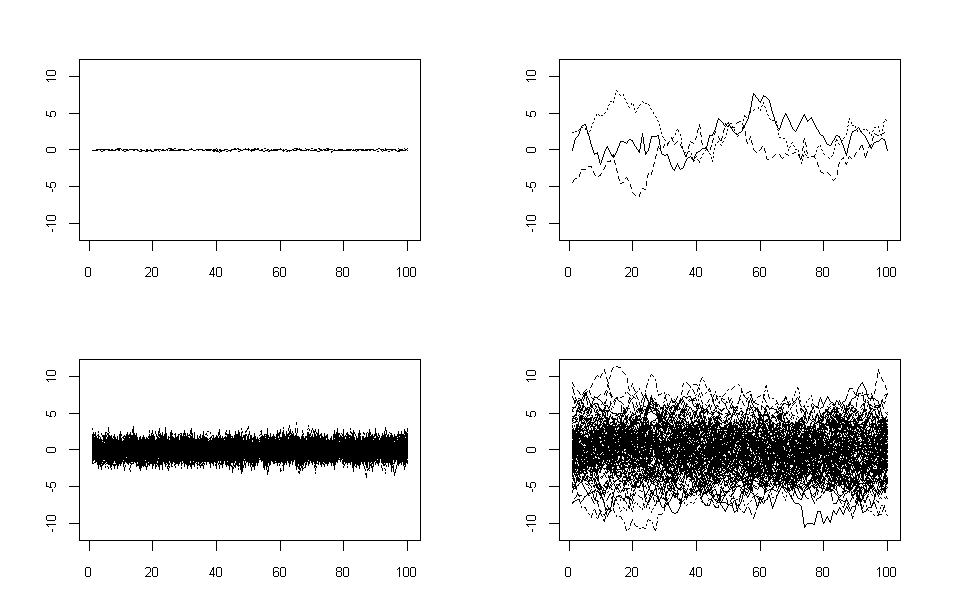

In [34]:
n   <- 100
phi <- 0.95
s   <- 0.1

options(repr.plot.width=8, repr.plot.height=5)                        #set dimensions of jupyter plot window
X1 <- replicate(3,rnorm(n,sd=s))
X2 <- replicate(3,arima.sim(100,model=list(ar=phi,sd=s)))
X3 <- replicate(100,rnorm(100))
X4 <- replicate(100,arima.sim(100,model=list(ar=phi)))
yr <- max(abs(c(X1,X2,X3,X4)))
par(mfrow=c(2,2),mar=c(3,4,3,3),cex.axis=0.8)                        #set matrix layout c(2,2), margin width, and axis label size of R plots
	matplot(X1,type='l',ylab='',xlab='',col='black',ylim=c(-yr,yr))  #iid process; 3 realizations; matplot() plots columns of matrix simultaneouly, replicate() generates matrix with the given sample realizations as its columns
	matplot(X2,type='l',ylab='',xlab='',col='black',ylim=c(-yr,yr))  #autoregressive model with autoregressive coefficient 0.95; 3 realizations
	matplot(X3,type='l',ylab='',xlab='',col='black',ylim=c(-yr,yr))  #iid process; 100 realizations
	matplot(X4,type='l',ylab='',xlab='',col='black',ylim=c(-yr,yr))  #autoregressive; 100 realizations

### Exercise
In the cell below, try altering the *ar*, *s*, and *n* parameters to see how the parameters alter the characteristic flucuations of the time series. Remember, there is nothing going on in these time series except for random noise and autocorrelation.

Try fitting the simple trend above to several of the simulated time series to see how often we find significant trends

##  Autocovariance
Now that we have seen how autocorrelation parameter alters the behaviour of time series, we are going to more formally extend the concept of covariance. Instread of thinking about covariance as between two different variables $x$ and $y$, like we did above, think of covariance among different time points in a single time series $x$ (here referring to a general $x$ that could, for example, represent $y_i$ or $e_i$ in our trend regression above). In a similar way to how we defined covariance between $x$ and $y$, we can describe autocorrelation as the following

$$ \mathrm{cov}(x_i,x_{i+\tau}) = \mathrm{E}\left[ (x_i-\mathrm{E}[x])(x_{i+\tau}-\mathrm{E}[x]) \right] $$

where $\tau$ is the distance, or *lag* separating the two elements in the time series. If points in time are independent in time, then $\mathrm{cov}(x_i,x_{i+\tau}) = 0$ theoretically, and $\hat{\mathrm{cov}}(x_i,x_{i+\tau}) = 0$ on average.


## The autocorrelation function
And like above, we'll consider covariance matrices where a single variance can be separated from the pattern of correlations among the variables. Writing the elements of the correlation matrix with generic values

$$ \mathbf{\Sigma} = \sigma^2 \begin{bmatrix}
         	      1 &     c(x_1,x_2) &     c(x_1,x_3) &          \dots & c(x_1,x_n) \\
         c(x_2,x_1) &              1 &     c(x_2,x_3) &         \ddots & c(x_2,x_n)  \\
         c(x_3,x_1) &     c(x_3,x_2) &              1 &         \ddots & \vdots \\
             \vdots &         \ddots &         \ddots &         \ddots & c(x_{n-1},x_n)  \\
         c(x_n,x_1) &     c(x_n,x_2) &          \dots & c(x_n,x_{n-1}) & 1     \end{bmatrix} $$

where $c(x_i,x_j)$ is the correlation between variable $x_i$ and $x_j$. What we want is a function that can be used to 'fill in' the values of this correlation matrix, and then we can go ahead and incorporate this matrix into our analyses. Very commonly in natural processes, the autocorrelation function for a dataset will take a form where values closer to another are more similar. This general situation requires an autocorrelation that take *distance* or *lag* between variables as its input

$$ c(x_t,x_{t+\tau}) = \mathrm{cor}(x_t,x_{t+\tau}) $$

In this case we are taking about lags in time, but we'll see later on the concept generalizes to spatial dimensions as well.

## The empirical autocorrelation function
Analogous to theoretical and empirical covariances, we can think about either theoretical and empirical autocorrelation functions. The empirical autocorrelation is actually easy to understand. With a sample of data we can form *lagged pairs* with a time series and estimate their correlation. That is, copy the time series and shift the second in time and calculate the resulting correlation between the original and shifted vectors.

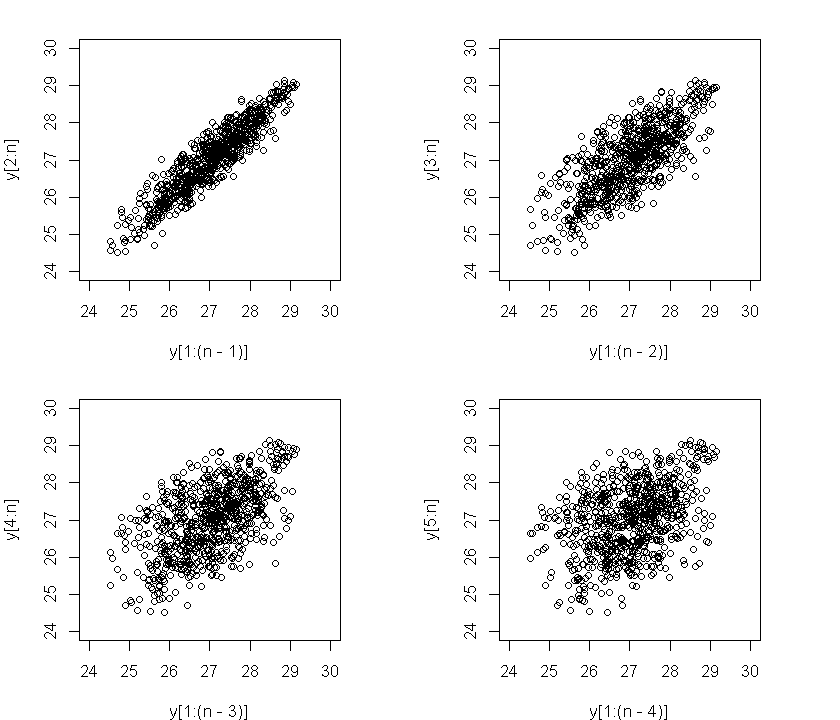

In [35]:
sst <- read.table('../../Data/detrend.nino34.ascii.txt',header=TRUE) #download sea surface temperature monitoring data from NOAA website
y   <- sst$TOTAL      #extract the observed sst and store it as variable y
n   <- length(y)      #extract the number of observations
options(repr.plot.width=7, repr.plot.height=6)     
par(mfrow=c(2,2),mar=c(4,4,2,4))
plot(y[1:(n-1)],y[2:n],ylim=c(24,30),xlim=c(24,30))
plot(y[1:(n-2)],y[3:n],ylim=c(24,30),xlim=c(24,30))
plot(y[1:(n-3)],y[4:n],ylim=c(24,30),xlim=c(24,30))
plot(y[1:(n-4)],y[5:n],ylim=c(24,30),xlim=c(24,30))

In ``R`` we can compute the correlations from all these lagged pairs via the convienient command ``acf()`` which will also make a nice plot for us. And note that we can standardize relative to the total variance, or not, yielding the *autocorrelation* and *autocovariance* functions, respectively.

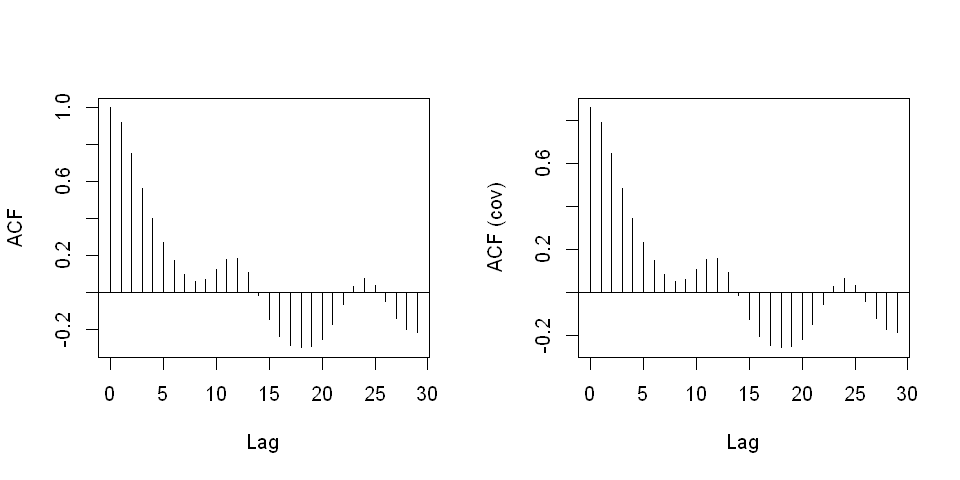

In [36]:
options(repr.plot.width=8, repr.plot.height=4)     
par(mfrow=c(1,2))
acf(y, ci=0, main='', type='correlation')
acf(y, ci=0, main='', type='covariance')

## Autoregressive autocorrelation function
It turns out that our first order autoregressive process ($AR1$) has a very nice formula to fill in the values of our correlation matrix

$$ c(x_t,x_{t+\tau}) = \phi^{\tau}. $$ 

which says that the correlation is simply a function of lag between pointsm and by knowing $\phi$ we can fill in the values of the matrix. This will the central autocorrelation function we use to analyze time series. It is perhaps the most fundamental and widely used time series model for a variety of purposes. The first order autoregressive covariance matrix is written  

$$ \mathbf{\Sigma}_{AR1} = \sigma^2 \begin{bmatrix}
	  	       1 &   \phi & \phi^2 &  \dots & \phi^n \\
  		  \phi &        1 &  \phi &  \ddots & \phi^{n-1} \\
        \phi^2 &     \phi &     1 &  \ddots & \vdots \\
        \vdots &   \ddots &\ddots &  \ddots & \phi^{n-(n-1)}  \\
        \phi^n &\phi^{n-1}  & \dots & \phi^{n-(n-1)} & 1     \end{bmatrix} $$
               
To understand where the formula comes from we can observe the following

$$ \mathrm{E}[x_{t}] = \phi \mathrm{E}[x_{t-1}] = \phi^2 \mathrm{E}[x_{t-2}] = \phi^{\tau} \mathrm{E}[x_{t-\tau}] $$

which says the shared variance between between $x_t$ and $x_{t+\tau}$ decreases by a factor of $\phi^{\tau}$. Remember that $\phi$ is a value with $|\phi|$ and so $|\phi^{\tau}|$ is a decreasing function with increasing $\tau$. 

Now we will try to estimate an autocorrelation function from the time series. First we find the empirical correlation between values lagged by one unit. We then construct the *theoretical autocorrelation function* according to the first order autoreggressive model. Overtop we plot the *empirical autocorrelation function* using the ``R`` command ``acf()`` which does the work for you by taking the time series, laging by $\tau$ units and computing the correlation. The third panel plots an *optimized* value for the autocorrelation function which comes from statistically fitting a curve to the empirical autocorrelation function. We'll learn how to do this below. For now, recognize that the empirical autocorrelation has some noise and while the autoregressive model appears to be a good functional form, we can find a better characterize via a statistical fit. There appears to be some cyclic structure in the correlations. We will get to that later when we address periodicity.

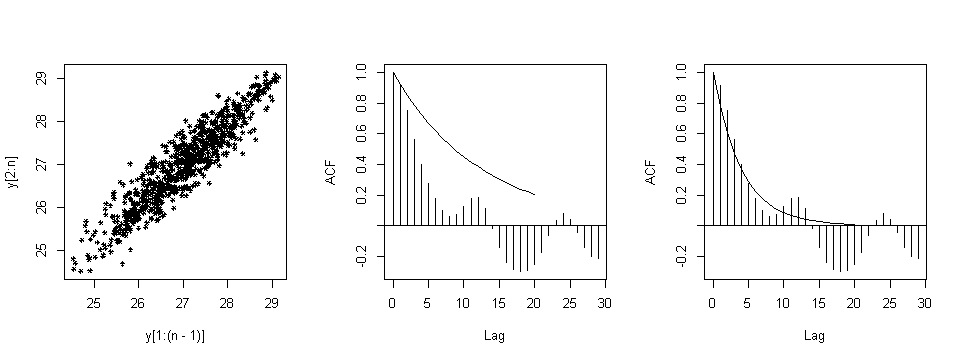

In [37]:
options(repr.plot.width=8, repr.plot.height=3)
par(mfrow=c(1,3))                                   #set the plot matrix layout c(1,2)
plot(y[1:(n-1)],y[2:n],pch=8,cex=0.5)               #scatterplot with values lagged by 1 unit
alpha_hat <- cor(y[1:(n-1)],y[2:n])                 #the correlation coefficient between lagged values
acf(y,demean=TRUE,ci=0,main='',type='correlation')  #estimate and plot the empirical autocorrelation function
    lines(seq(0,20),alpha_hat^seq(0,20))            #add line for threoretical acf using correlation coefficient                        #add line for threoretical acf using slope
acf(y,demean=TRUE,ci=0,main='',type='correlation')  #estimate and plot the empirical autocorrelation function
    lines(seq(0,20),0.78^seq(0,20))                 #plot the optimized autocorrelation function (more info below)

## Linear regression with autocorrelation
To show you how modeling autocorrelation works in practice, we again look back to our El Nino time series regression. From observing the plot of El Nino data it appears that the observed sst $y$ has autocorrelation - i.e. *values closer to one another seem more similar than values far away*. And although we have not visualized $e_i$, we know from the model that $e$ and $y$ only differ via the subtraction of a straight line, so temporal flucuations in $y_i$ will propagate to $e_i$. So in a nutshell, it looks like the assumption of independence in violated.

We can write the likelihood function for the correlated data as follows, now incorporating the general covariance matrix

$$ p(\mathbf{y} | \mathbf{\theta},M, \mathbf{\Sigma}) = \prod_{i=1}^n p(y_i | \mathbf{\theta},M,\mathbf{\Sigma}) = 
	\frac{1}{(2\pi)^{\frac{n}{2}}|\mathbf{\Sigma}|^{\frac{1}{2}}} 
	\mathrm{exp} \left( -\frac{1}{2} \mathbf{e}'\mathbf{\Sigma}^{-1}\mathbf{e}  \right) $$

In the same way we had an expression for maximizing the probability of independent data, there is a formula for the regression parameters in the presents of autocorrelation. This is known as generalized least squares (https://en.wikipedia.org/wiki/Generalized_least_squares).

$$ \mathbf{\hat{\beta}} = \mathbf{(X'\Sigma^{-1}X)^{-1}X'\Sigma^{-1}y}  $$

To fit this model in ``R`` we will use the ``nlme`` package which is a general set of functions for a wide variety of statistical modeling. Let's go ahead and fit it:

In [38]:
sst <- read.table('../../Data/detrend.nino34.ascii.txt',header=TRUE) #extract observed sea surface temperature from the NOAA website
y   <- sst$TOTAL                                                     #extract the observed sea surface temperature
t   <- seq(1950,2017,length.out=nrow(sst))                           #define time variable with same number of years as the data 

In [39]:
summary(gls(y ~ t, correlation=corAR1(), method='ML'))   #fit a linear regression between y and time, specifying a first order autoregressive covariance matrix. Specify method='ML' to fit exact maximum likelihood  

Generalized least squares fit by maximum likelihood
  Model: y ~ t 
  Data: NULL 
       AIC      BIC    logLik
  627.5535 646.3268 -309.7768

Correlation Structure: AR(1)
 Formula: ~1 
 Parameter estimate(s):
      Phi 
0.9222667 

Coefficients:
               Value Std.Error   t-value p-value
(Intercept) 6.131857 15.776627 0.3886672  0.6976
t           0.010514  0.007954 1.3219154  0.1866

 Correlation: 
  (Intr)
t -1    

Standardized residuals:
       Min         Q1        Med         Q3        Max 
-2.5647249 -0.6749418  0.1034492  0.7083635  2.1403002 

Residual standard error: 0.9178044 
Degrees of freedom: 807 total; 805 residual

So that was easy. Things look very similar to fitting an ordinary least squares regression for independent data. But what did we do? We passed the critical command to ``R`` specifying the correlation structure ``corAR1()`` which indicates to fit a covariance matrix like the one we looked at above. Note the ``method='ML'`` tells ``R`` to use direct maximum likelihood estimation so we can interpret the objective function value which will be helpful below. You should note one critical thing with this fit. We told ``R`` to specify the correlation *structure* but we did not give it a correlation parameter $\phi$. But as you see, the output from ``gls()`` returns a value. This is the optimized value yielded by numerically maximizing a likelihood with respect to this parameter. Notably, the t-statistic is considerably smaller than with our assumption of ! Previously we had calculated a $t$ of 4.961 which strongly suggests a statistical trends, while here our $t$ statistic is ~3.5x smaller. Also note that our linear slope is about 25% larger in magnitude here as well. This often happens. But there is an important result from statistics that says the slope in the two cases should not be systematically different (i.e. the estimate is unbiased *on average*), whereas the uncertainty is biased in the sense that ignoring autocorrelation will almost always result in *overconfidence*.  

## Analysis of Orange Country ozone time series
Now lets' dig into a higher resolution, multidimentional dataset, analyzing the air quality monitoring data from Orange Country, provided by Enrivionmental Protection Agency (EPA). These data are readily used for cutting edge research purposes. In fact, you can find a very recent 2017 PNAS paper analyzing these data and published by an Earth System Science graduate student right here: https://goo.gl/eYTS1O. The larger dataset, including weather stations all over the USA and many more measured parameters, available for download from the EPA here: https://goo.gl/QxJv0y. 

So first we will read in the dataset. For some unknown reason, the EPA website provides data to 2014 with an incomplete 2016 year. To make thing simple we just drop the 2016 year.

In [40]:
d  <- read.csv('../../Data/ozone_orange.csv',stringsAsFactors=FALSE)
d  <- d[d$year!=2016,]                                     #incomplete chunk of observation, remove for simplicity, using only data before 2016

## Simple trend analysis
Let's try investigating simple linear trends in the ozone data. We're again going to use the ``nlme`` pacakge in ``R`` which optimizes the autoregressive coefficient and accounts for the covariance when calculating uncertainty.  

In [41]:
y1 <- d$ozone                                              #extract the daily mean ozone variable
t  <- seq(min(d$year),max(d$year),length.out=length(y1))   #define time variable
summary(gls(y1 ~ t, correlation=corAR1(), method='ML'))    #display the summary of a fitted regression with autoregressive covariance matrix  

Generalized least squares fit by maximum likelihood
  Model: y1 ~ t 
  Data: NULL 
        AIC       BIC   logLik
  -21910.74 -21886.67 10959.37

Correlation Structure: AR(1)
 Formula: ~1 
 Parameter estimate(s):
      Phi 
0.8552849 

Coefficients:
                  Value Std.Error     t-value p-value
(Intercept)  0.03422281 0.6293315  0.05437963  0.9566
t           -0.00000413 0.0003138 -0.01316690  0.9895

 Correlation: 
  (Intr)
t -1    

Standardized residuals:
         Min           Q1          Med           Q3          Max 
-2.056608887 -0.800994961  0.009574762  0.706174031  3.184672958 

Residual standard error: 0.01261744 
Degrees of freedom: 3035 total; 3033 residual

## Harmonic regression
Now we consider another key aspect of time series analysis: *periodicity* or *seasonality*. A yearly seasonal cycle is common in environmental data, but there are often other daily and other periodicities as well. For example, El Nino has a somewhat irregular periodicity, with a mean period of approximately seven years. Other environmental phenomena have different periods, including daily, monthly, multidecadal, as well as longer periods present in geological timescales. Of course we didn't have environmental sensors back then, but geologists use time series analysis of so-called *proxy records* which they analyze to understand much longer periods. 

In general we  describe periodicities with sines and cosines, of varying complexity depending on the complexity of the periodic pattern. The simplest form is a single frequency decribed by a single term 

$$ x_t = A\cos(2\pi \omega t + \zeta) $$

$A$ is the amplitude, $\omega$ is the frequency , and $\zeta$ is the phase. Although conceptually simple, this term actually poses a bit of a problem for our linear regression framwork since the phase parameter enters the model nonlinearly and some more complex statistics would be required to fit it. Rest assured there is a common fix to this, involving the double angle formula we learned way back when

$$ \cos(a+b) = \cos(a)\cos(b) - \sin(a)\sin(b).  $$

This formula convieniently allows us to use two linear terms to model a single period within a linear regression while accounting for the phase. Note the phase no longer enters the model nonlinearly, defining $\beta_1 = A\cos(\zeta)$ and $\beta_2 = -A\sin(\zeta)$

Below we fit a seasonal cycle term. We first find the number of years in the time seasons (i.e. number of seasons) ``nyrs`` 

In [42]:
nyrs  	  <- max(d$year)-min(d$year)              #number of seasonal cycles [years]
f         <- seq(0,2*pi*nyrs,length.out=nrow(d))  #nyrs cycles over the length of the time series [radians]
	sinf  <- sin(f)                               #sine wave of f
	cosf  <- cos(f)                               #cose wave of f

In [43]:
summary(gls(y1 ~ sinf + cosf,correlation=corAR1(), method='ML'))   #fit regression with seasonal component and first order autoregressive covariance matrix

Generalized least squares fit by maximum likelihood
  Model: y1 ~ sinf + cosf 
  Data: NULL 
        AIC       BIC   logLik
  -22053.52 -22023.43 11031.76

Correlation Structure: AR(1)
 Formula: ~1 
 Parameter estimate(s):
      Phi 
0.7700548 

Coefficients:
                  Value    Std.Error  t-value p-value
(Intercept) 0.025893952 0.0005036630 51.41126  0.0000
sinf        0.000891778 0.0007113883  1.25357  0.2101
cosf        0.010826465 0.0007096038 15.25706  0.0000

 Correlation: 
     (Intr) sinf  
sinf  0.000       
cosf -0.004  0.000

Standardized residuals:
        Min          Q1         Med          Q3         Max 
-2.97903286 -0.72563451 -0.03934443  0.67355001  3.73500124 

Residual standard error: 0.0100069 
Degrees of freedom: 3035 total; 3032 residual

## Time series decomposition
So now we have seen how to fit both linear trends and periodic regression terms. The best estimate for the individual terms is when you fit these terms simultaneously. Fitting multiple terms like this is often referred to as *time series decomposition* Below we fit the model simultaneously and then plot the individual terms 

In [44]:
fit     <- gls(y1 ~ sinf + cosf + t,correlation=corAR1(), method='ML')  #store the model object from the fit above
k_hat   <- summary(fit)$t                                               #extract fitted regression coefficients
phi_hat <- coef(fit$model$corStruct,unconstrained=FALSE)                #extract fitted autoregressive parameter
e       <- residuals(fit,'response')                                    #extract 'raw' residuals (yi - ypred) 
n       <- length(e)                        

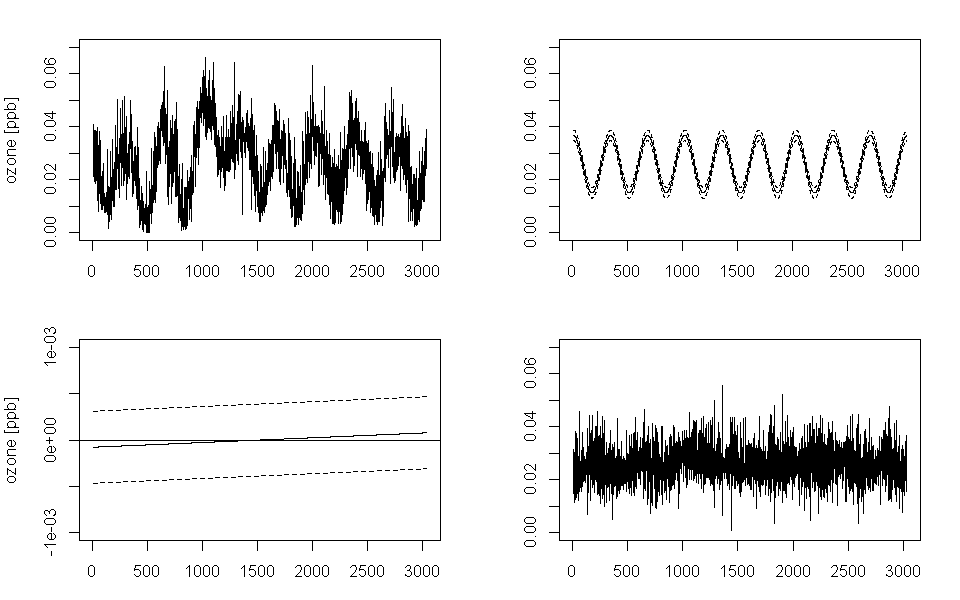

In [45]:
options(repr.plot.width=8, repr.plot.height=5)
par(mfrow=c(2,2),mar=c(3,4,2,2))
plot(y1,type='l',ylim=c(0,0.07),ylab='ozone [ppb]')                       #plot the data

f_hat <- mean(y1) + k_hat[2,1]*sinf + k_hat[3,1]*cosf                     #fitted seasonal cycle
plot(f_hat,type='l',ylim=c(0,0.07),ylab='')                               #plot fitted seasonal cycle
	lines(f_hat + 2*sqrt(k_hat[2,2]^2 + k_hat[3,2]^2),lty=2)              #add 95% CIs (upper)
	lines(f_hat - 2*sqrt(k_hat[2,2]^2 + k_hat[3,2]^2),lty=2)              #add 95% CIs (lower)

t_hat <- k_hat[1,1] + k_hat[4,1]*t                                        #fitted trend
t_hat <- t_hat - mean(t_hat)                                              #normalize to the zero-line   
plot(t_hat, type='l',ylim=c(-0.001,0.001),ylab='ozone [ppb]')             #plot the values
	lines(t_hat + 2*k_hat[4,2],lty=2)                                     #upper 95% CI
	lines(t_hat - 2*k_hat[4,2],lty=2)                                     #lower 95% CI
	abline(h=0)                                                           #add the zero-line
ear <- e[2:n]-phi_hat*e[1:(n-1)]                                          #subtract the autoregression
plot(mean(y1)+ear,type='l',ylim=c(0,0.07),ylab='')                        #plot the residuals

The first three plots should be clear, but the fourth may not be. We took the residuals from model after removing the fitted terms, and then subtracted the estimated autocorrelation function by forming the residuals $e = e^{raw}_{2:n} - \phi e^{raw}_{1:(n-1)} $. 

### Exercise
In the cell below, fit other variables in the ozone dataset. Include a trend and the appropriate seasonal terms. Do any other variables show evidence for a trend after controlling for these effects? 

## Time series regression
Just like we fit regression using a time variable, we can fit regressions using other independent variables. We can fit the following model

$$ y_i = \beta_0 + \beta_1 x_{1,i} + \beta_{2} x_{2,i}\; + ,\dotsb,  +\; \beta_n x_{n,i} + e_i $$

these variables can be periodic variables or other independent variables in the dataset. And like above, we characterize the covariance matrix $\Sigma$ using the autoregressive correlation function. 

In R:

In [46]:
x1  <- d$temp      #extract temperature variable
x2  <- d$windsp    #extract wind speed
x3  <- d$winddir   #extract wind direction
fitx1   <- gls(y1 ~ sinf + cosf + x1,correlation=corAR1(), method='ML')    #fit regression with seasonal terms, one input, with autoregressive correlation matrix  
fitx123 <- gls(y1 ~ sinf + cosf + x1 + x2 + x3,correlation=corAR1(), method='ML')   #fit linear regression with seasonal cycle and three independent variables; fit via maximum likelihood method='ML'
data.frame(Model=c('fitx1','fitx123'),
           R2=c(round(cor(y1,predict(fitx1))^2,3)*100, round(cor(y1,predict(fitx123))^2,3)*100),
           BIC=BIC(fitx1,fitx123)$BIC)
summary(fitx1)
summary(fitx123)        #display summary of the fitted model


Model,R2,BIC
fitx1,37.4,-22015.87
fitx123,44.2,-22562.85


Generalized least squares fit by maximum likelihood
  Model: y1 ~ sinf + cosf + x1 
  Data: NULL 
        AIC       BIC   logLik
  -22051.98 -22015.87 11031.99

Correlation Structure: AR(1)
 Formula: ~1 
 Parameter estimate(s):
      Phi 
0.7687963 

Coefficients:
                  Value    Std.Error   t-value p-value
(Intercept) 0.024437725 0.0021696121 11.263638  0.0000
sinf        0.000793210 0.0007218835  1.098807  0.2719
cosf        0.010728155 0.0007200955 14.898239  0.0000
x1          0.000022837 0.0000331050  0.689847  0.4903

 Correlation: 
     (Intr) sinf   cosf  
sinf  0.193              
cosf  0.192  0.039       
x1   -0.973 -0.198 -0.198

Standardized residuals:
        Min          Q1         Med          Q3         Max 
-2.97991106 -0.72750894 -0.04116506  0.67466560  3.74885029 

Residual standard error: 0.009982415 
Degrees of freedom: 3035 total; 3031 residual

Generalized least squares fit by maximum likelihood
  Model: y1 ~ sinf + cosf + x1 + x2 + x3 
  Data: NULL 
     AIC       BIC  logLik
  -22611 -22562.85 11313.5

Correlation Structure: AR(1)
 Formula: ~1 
 Parameter estimate(s):
      Phi 
0.7868927 

Coefficients:
                   Value    Std.Error   t-value p-value
(Intercept)  0.020406707 0.0021083140  9.679159  0.0000
sinf         0.001603743 0.0007131025  2.248965  0.0246
cosf         0.010199741 0.0007180072 14.205625  0.0000
x1          -0.000111914 0.0000307147 -3.643677  0.0003
x2           0.002810266 0.0001128399 24.904898  0.0000
x3           0.000016128 0.0000034484  4.676984  0.0000

 Correlation: 
     (Intr) sinf   cosf   x1     x2    
sinf  0.179                            
cosf  0.215  0.039                     
x1   -0.895 -0.189 -0.177              
x2   -0.087  0.044 -0.032 -0.166       
x3   -0.324 -0.037 -0.152 -0.012  0.190

Standardized residuals:
        Min          Q1         Med          Q3         Max 

## Standardize regression variables for interpretation
Below we use the ``scale()`` command to remove variables' repsective means and divide by their respective standard deviations. This is the so-called *z-score transform*. It is very useful in statistics because it nondimentionalizes the data and puts everything on the same scale. Now the slope estimates provide estimates for the relative numerical importance of each variable.

In [47]:
x1nrm  <- scale(d$temp)      #scale() subtracts the mean and divides by the sd
x2nrm  <- scale(d$windsp)    
x3nrm  <- scale(d$winddir)   
sinfnrm<- scale(sinf)        #scale the periodic terms and can interpret the magnitudes relative to covariates
cosfnrm<- scale(cosf)
fitx1nrm   <- gls(y1 ~ sinfnrm + cosfnrm + x1nrm,correlation=corAR1(), method='ML')                   #fit regression with seasonal terms, one input, with autoregressive correlation matrix  
fitx123nrm <- gls(y1 ~ sinfnrm + cosfnrm + x1nrm + x2nrm + x3nrm,correlation=corAR1(), method='ML')   #fit linear regression with seasonal cycle and three independent variables; fit via maximum likelihood method='ML'
data.frame(Model=c('fitx1nrm','fitx123nrm'),
           R2=c(round(cor(y1,predict(fitx1nrm))^2,3)*100, round(cor(y1,predict(fitx123nrm))^2,3)*100),
           BIC=BIC(fitx1nrm,fitx123nrm)$BIC)
summary(fitx1nrm)
summary(fitx123nrm)        #display summary of the fitted model

Model,R2,BIC
fitx1nrm,37.4,-22015.87
fitx123nrm,44.2,-22562.85


Generalized least squares fit by maximum likelihood
  Model: y1 ~ sinfnrm + cosfnrm + x1nrm 
  Data: NULL 
        AIC       BIC   logLik
  -22051.98 -22015.87 11031.99

Correlation Structure: AR(1)
 Formula: ~1 
 Parameter estimate(s):
      Phi 
0.7687963 

Coefficients:
                  Value    Std.Error  t-value p-value
(Intercept) 0.025897857 0.0005009692 51.69550  0.0000
sinfnrm     0.000560884 0.0005104487  1.09881  0.2719
cosfnrm     0.007588450 0.0005093522 14.89824  0.0000
x1nrm       0.000174678 0.0002532121  0.68985  0.4903

 Correlation: 
        (Intr) snfnrm csfnrm
sinfnrm  0.000              
cosfnrm -0.003  0.039       
x1nrm    0.001 -0.198 -0.198

Standardized residuals:
        Min          Q1         Med          Q3         Max 
-2.97991106 -0.72750894 -0.04116506  0.67466560  3.74885029 

Residual standard error: 0.009982415 
Degrees of freedom: 3035 total; 3031 residual

Generalized least squares fit by maximum likelihood
  Model: y1 ~ sinfnrm + cosfnrm + x1nrm + x2nrm + x3nrm 
  Data: NULL 
     AIC       BIC  logLik
  -22611 -22562.85 11313.5

Correlation Structure: AR(1)
 Formula: ~1 
 Parameter estimate(s):
      Phi 
0.7868927 

Coefficients:
                   Value    Std.Error  t-value p-value
(Intercept)  0.025896099 0.0004954634 52.26642  0.0000
sinfnrm      0.001134018 0.0005042396  2.24897  0.0246
cosfnrm      0.007214682 0.0005078750 14.20563  0.0000
x1nrm       -0.000856006 0.0002349291 -3.64368  0.0003
x2nrm        0.002867388 0.0001151335 24.90490  0.0000
x3nrm        0.000674231 0.0001441593  4.67698  0.0000

 Correlation: 
        (Intr) snfnrm csfnrm x1nrm  x2nrm 
sinfnrm  0.000                            
cosfnrm -0.004  0.039                     
x1nrm    0.001 -0.189 -0.177              
x2nrm    0.000  0.044 -0.032 -0.166       
x3nrm    0.001 -0.037 -0.152 -0.012  0.190

Standardized residuals:
        Min          Q1         Me

### Exercise
Investigate the dataset and try to find a set of variables that appear strongly associated with ozone. Standardize the variables and rank the variables in terms of their slope and their slope t-values. 

## Model Selection
When we fit the model with an increasing number of parameters we saw the $R^2$ increase. In fact, $R^2$ always increases with more parameters for linear models. We would therefore like a better metric to determine whether one models statistically fits better than another. There are common metrics used in some cases based on *p.value* calculations, but another more general metric is known as the *Bayesian infromation criterion* (BIC; also known as the Schwartz criterion), and the related *Akakie information criterion* (AIC). Both are based on our likelihood 

$$ p(\mathbf{y} | \mathbf{\theta},M, \mathbf{\Sigma}) = \prod_{i=1}^n p(y_i | \mathbf{\theta},M,\mathbf{\Sigma}) = 
	\frac{1}{(2\pi)^{\frac{n}{2}}|\mathbf{\Sigma}|^{\frac{1}{2}}} 
	\mathrm{exp} \left( -\frac{1}{2} \mathbf{e}'\mathbf{\Sigma}^{-1}\mathbf{e}  \right) $$

where $\mathbf{\theta}$ are the parameters of the model, and $\mathbf{\Sigma}$ is the covariance matrix of the errors.

When we numerically optimize this function to yield *maximum likelihood estimates* we can evaluate the likelihood at the maximum likelihood parameters 

$$ p(\mathbf{y} | \mathbf{\hat{\theta}},M, \mathbf{\hat{\Sigma}}) = \prod_{i=1}^n p(y_i | \mathbf{\theta},M,\mathbf{\Sigma}) = 
	\frac{1}{(2\pi)^{\frac{n}{2}}|\mathbf{\Sigma}|^{\frac{1}{2}}} 
	\mathrm{exp} \left( -\frac{1}{2} \mathbf{e}'\mathbf{\Sigma}^{-1}\mathbf{e}  \right) $$
    
Note that the quantity $p(\mathbf{y} | \mathbf{\theta},M, \mathbf{\Sigma})$ is a general conditional distribution without specified $\mathbf{\theta},M, \mathbf{\Sigma}$, whereas $p(\mathbf{y} | \mathbf{\hat{\theta}},M, \mathbf{\hat{\Sigma}})$ is evaluated with specific parameter values and so evaluates to yield a single numerical value. The BIC is then evaluated as a single number

$$ \mathrm{BIC} = -2\log p(\mathbf{y} | \hat{\mathbf{\theta}},M,\hat{\sigma}^2) + k\log n $$

where $k$ is the number of estimated parameters in the model, and $n$ is the length of the time series. 

In [48]:
data.frame(
    model= c('fitx1','fitx123'),                                       #model labels
    R2   = c(cor(y1,predict(fitx1))^2, cor(y1,predict(fitx123))^2),    #percent varation explained by the prediction
    logl = c(summary(fitx1)$logLik,   summary(fitx123)$logLik),  
    k    = c(summary(fitx1)$dims$p,    summary(fitx123)$dims$p),       #number of parameters in the models
    BIC  = c(summary(fitx1)$BIC,       summary(fitx123)$BIC))          #Bayesian information criterion

model,R2,logl,k,BIC
fitx1,0.3740440,11031.99,4,-22015.87
fitx123,0.4420161,11313.50,6,-22562.85


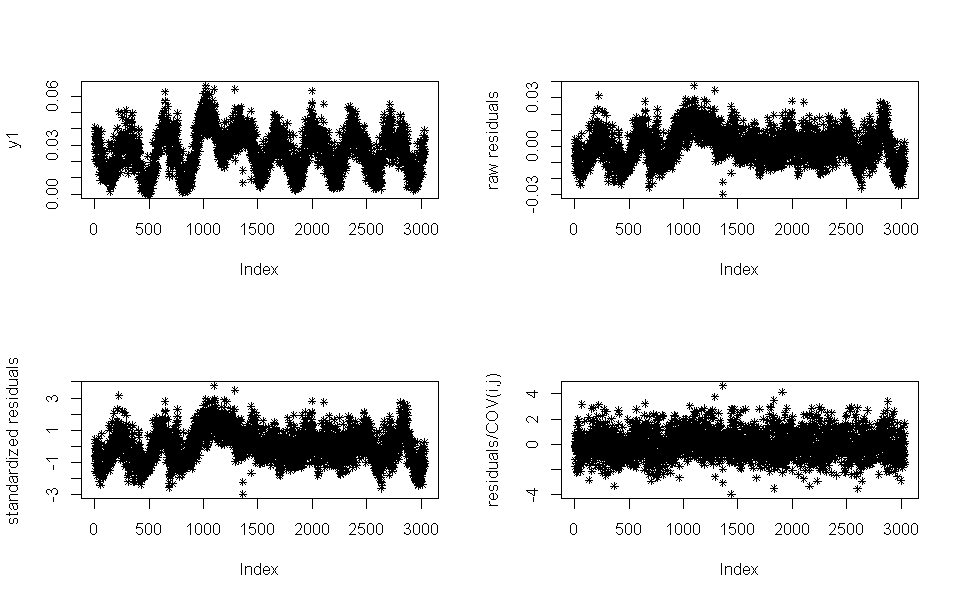

In [49]:
par(mfrow=c(2,2))
plot(y1,pch=8,cex=0.7)
plot(residuals(fitx1, 'response'),pch=8,cex=0.7,ylab='raw residuals')         #'raw' residuals
plot(residuals(fitx1, 'pearson'),pch=8,cex=0.7,ylab='standardized residuals') #normalized to have unit variance
plot(residuals(fitx1, 'normalized'),pch=8,cex=0.7,ylab='residuals/COV(i,j)')  #residuals after removing the autocorrelation